In [1]:
%pip -q install -U imbalanced-learn
%pip -q install numpy
%pip -q install matplotlib
%pip -q install sklearn
%pip -q install imblearn

  Preparing metadata (setup.py) ... done


In [2]:
# @title Importing the Libraries
import pandas as pd

import numpy as np

import matplotlib as plt

import csv

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

First we import all the required libraries.

# Cleaning the Dataset

In [3]:
# @title Removing the added rows
data = []
with open("/content/protein_trn_data (4).csv") as file:#change the file name
    csv_reader = csv.reader(file)
    for row in csv_reader:
        # Check if the number of columns is greater than expected
        if len(row) > 14:
            # Remove the first column and keep only the next 14 columns
            row = row[1:15]

        data.append(row)

ptrn = pd.DataFrame(data)

ptrn.to_csv('ptrn 01.csv', index = False)

protein = pd.read_csv('ptrn 01.csv')#save it in your directory
print(protein.info())
print(protein.head())
num_rows,num_columns = protein.shape
print("num_rows",num_rows)
print("num_columns",num_columns)

<ipython-input-3-4ef594035e2a>:17: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  protein = pd.read_csv('ptrn 01.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125454 entries, 0 to 125453
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       125454 non-null  object 
 1   1       125454 non-null  object 
 2   2       122151 non-null  object 
 3   3       125447 non-null  object 
 4   4       114241 non-null  object 
 5   5       125444 non-null  object 
 6   6       85747 non-null   object 
 7   7       86462 non-null   object 
 8   8       110791 non-null  object 
 9   9       110819 non-null  object 
 10  10      105408 non-null  object 
 11  11      93401 non-null   object 
 12  12      104185 non-null  object 
 13  13      26 non-null      float64
dtypes: float64(1), object(13)
memory usage: 13.4+ MB
None
             0                      1                  2             3  \
0  structureId  experimentalTechnique  macromoleculeType  residueCount   
1         3F6D      X-RAY DIFFRACTION            Protein           438   


Here we input the data and check if there are more than 14 rows if yes the rows are shifted to the left.

In [4]:
def load_data(filepath, head):
    df = pd.read_csv(filepath, low_memory=False, header = head)
    # Add any specific preprocessing steps here (e.g., handling missing values, feature scaling)
    return df

In [5]:
# Load datasets
protrn = load_data('/content/ptrn 01.csv', 1)#change directory
plabel = load_data('/content/protein_trn_class_labels (4).csv', None)#change directory

In [6]:
protrn.reset_index(drop=True, inplace=True)

In [7]:
protrn

,structureId,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,Unnamed: 13
0,3F6D,X-RAY DIFFRACTION,Protein,438,1.7,50637.53,"VAPOR DIFFUSION, HANGING DROP",298,1.95,36.97,"30% (w/v) PEG 4000, 0.1M Sodium Cacodylate pH ...",6.6,2010,NaN
1,4PLT,X-RAY DIFFRACTION,Protein,1324,1.6,148853.81,"VAPOR DIFFUSION, HANGING DROP",293,2.48,50.38,20mg/mL protein with 2mM NADH/L-oxamate; well ...,7.5,2014,NaN
2,2YEF,X-RAY DIFFRACTION,Protein,252,1.55,29054.37,NaN,NaN,2.03,39.29,pH 6.5,6.5,2011,NaN
3,5UJF,X-RAY DIFFRACTION,Protein,180,2.3,20674.23,"VAPOR DIFFUSION, SITTING DROP",289,2.63,52.00,Crystal Screen HT condition C6: 200mM Ammonium...,7.5,NaN,NaN
4,1U88,X-RAY DIFFRACTION,Protein,436,3.5,51456.98,"VAPOR DIFFUSION, SITTING DROP",297,2.7,54.00,"0.2M sodium citrate, 2M ammonium sulphate, pH ...",5.6,2005,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125448,5FMJ,X-RAY DIFFRACTION,Protein,192,2.43,22023.59,NaN,NaN,2.97,58.58,"0.2 M SODIUM THIOCYANATE, 20% PEG 3350",NaN,2016,NaN
125449,2YKZ,X-RAY DIFFRACTION,Protein,127,0.84,14470.12,NaN,NaN,2.74,55.19,"AMMONIUM SULPHATE, TRIS PH 7.5 .",7.5,2011,NaN
125450,2KPB,SOLUTION NMR,Protein,26,NaN,3083.67,NaN,NaN,NaN,NaN,NaN,NaN,2010,NaN
125451,4GMZ,X-RAY DIFFRACTION,Protein,613,2.05,69425.64,"VAPOR DIFFUSION, HANGING DROP",298,2.2,44.09,"22-26% PEG3350, 0.1 M HEPES, pH 7.4, 10 mM man...",7.4,2012,NaN


Then we load the partially cleaned dataset and the class labels.

In [8]:
def correct_misalignment(row):
    # Check if structureId has more than 4 characters (indicating misalignment)
    if len(row['structureId']) > 4:
        # Correct the structureId by keeping only the first 4 characters
        # row['structureId'] = row['structureId'][:4]
        # Shift all the subsequent columns to the left
        row[1:-1] = row[2:]
    return row

# Apply the correction to each row
protrn = protrn.apply(correct_misalignment, axis=1)

protrn.to_csv('prottrn.csv', index= False)#save it in your directory

In [9]:
ptrn = load_data('/content/prottrn.csv', 0)

Then we clean the dataset based on the fact that StructureID should only be 4 cahracters long. If that is not the case the rows are moved to the left.

In [10]:
plabel.columns = ['Num', 'class']

In [11]:
plabel = plabel.drop('Num', axis= 1)

In [12]:
pr = ptrn.join(plabel, how = 'left')

In [13]:
pr["crystallizationMethod"].replace({"VAPOR DIFFUSION, HANGING DROP" : "VAPOR DIFFUSION",
                                       "VAPOR DIFFUSION, SITTING DROP" : "VAPOR DIFFUSION",
                                       "VAPOR DIFFUSION" : "VAPOR DIFFUSION",
                                       "EVAPORATION" : "EVAPORATION",
                                       "MICROBATCH" : "MICROBATCH",
                                       "hanging drop" : "VAPOR DIFFUSION",
                                       "LIPIDIC CUBIC PHASE" : "LIPIDIC CUBIC PHASE",
                                       "SMALL TUBES" : "Miscellaneous",
                                       "MICRODIALYSIS" : "MICRODIALYSIS",
                                       "BATCH MODE" : "MICROBATCH",
                                       "LIQUID DIFFUSION" : "Miscellaneous",
                                       "VAPOR DIFFUSION,SITTING DROP,NANODROP" : "VAPOR DIFFUSION",
                                       "batch" : "MICROBATCH",
                                       "microbatch under oil" : "MICROBATCH",
                                       "VAPOR DIFFUSION, SITTING DROP, NANODROP" : "VAPOR DIFFUSION"},
                                      inplace=True)

pr['crystallizationMethod'].nunique()

537

Then we drop the index column from the Labels dataset and join the training data and class labels data. Then we do some tuning to reduce uniques in the crystallization method feature.

In [14]:
pr.nunique()

structureId                 125045
experimentalTechnique           39
macromoleculeType              285
residueCount                  4653
resolution                    1009
structureMolecularWeight    115416
crystallizationMethod          537
crystallizationTempK           356
densityMatthews                981
densityPercentSol             6036
pdbxDetails                  81607
phValue                        369
publicationYear                 54
Unnamed: 13                     14
class                         2160
dtype: int64

In [15]:
prr = pr.drop(['publicationYear', 'structureId', 'pdbxDetails'], axis = 1)

We drop 3 feature as all of them have different unique values for every data points. This will be not helpful for the model as this does not provide any correlation with different data points.

In [16]:
imputer = SimpleImputer(strategy='most_frequent')
prr = pd.DataFrame(imputer.fit_transform(prr), columns=prr.columns)

We use Simple Imputer to impute the missing values, using the most frequent method.

In [17]:
prr = prr.dropna(how = 'any')
prr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125453 entries, 0 to 125452
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   experimentalTechnique     125453 non-null  object
 1   macromoleculeType         125453 non-null  object
 2   residueCount              125453 non-null  object
 3   resolution                125453 non-null  object
 4   structureMolecularWeight  125453 non-null  object
 5   crystallizationMethod     125453 non-null  object
 6   crystallizationTempK      125453 non-null  object
 7   densityMatthews           125453 non-null  object
 8   densityPercentSol         125453 non-null  object
 9   phValue                   125453 non-null  object
 10  Unnamed: 13               125453 non-null  object
 11  class                     125453 non-null  object
dtypes: object(12)
memory usage: 11.5+ MB


In [18]:
counts = prr['class'].value_counts()
class_data = np.asarray(counts[(counts > 900)].index)
prn = prr[prr['class'].isin(class_data)]
prn['class'].value_counts()
prn = pd.DataFrame(prn)

Then we filter the data based on the class labels as there are labels with less than 200 data points and others with 17000 data points which is causing the precision of the model to be very low.

<Axes: >

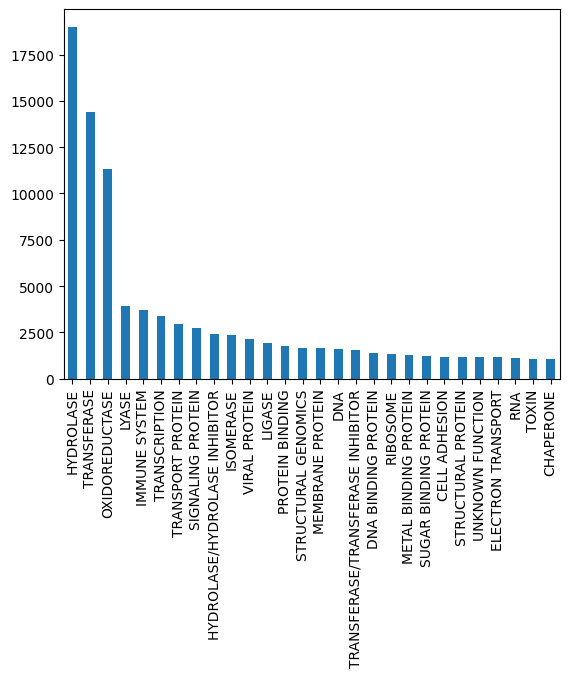

In [19]:
#plt.figure(figsize=(8,6))
prn['class'].value_counts()[:100].plot(kind='bar')

# Encoding, Splitting and Oversampling the Data

In [20]:
labelencoder=LabelEncoder()

for column in prn.columns:
    prn[column] = labelencoder.fit_transform(prn[column])

Then we use Label Encoder for encoding as encoding using one-hot method would be quite problematic with the amount of uniques in every feature.

In [21]:
X = prn.drop('class', axis = 1)
y = prn['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [22]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Training the model

Then we split the data and use SMOTE to oversample the data as there a large amount of imbalance in the dataset.

In [23]:
rfc = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier(n_neighbors= 11, leaf_size= 40, metric = 'manhattan', weights = 'distance')
dt = DecisionTreeClassifier(splitter = 'random', min_weight_fraction_leaf = 0.5, max_depth= 7, max_leaf_nodes= 60, min_samples_leaf= 4, min_samples_split= 20)

I used four models for training SVM, Random Forest, KNN, Decision Tree

In [24]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

In [25]:
def model(m):
  m.fit(X_train_smote, y_train_smote.ravel())
  print(round(m.score(X_test,y_test)*100,2))
  predictions = m.predict(X_test)
  accuracy, precision, recall, f1 = get_metrics(y_test, predictions)
  print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
  cm = confusion_matrix(y_test, predictions)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
  cm_display.plot()

In [26]:
models = (rfc, knn, dt)

I made a function to use for getting the  train the model, performance metrics and display confusion matrix

45.88
accuracy = 0.459 
precision = 0.477 
recall = 0.459 
f1 = 0.465
31.5
accuracy = 0.315 
precision = 0.481 
recall = 0.315 
f1 = 0.343
1.26
accuracy = 0.013 
precision = 0.000 
recall = 0.013 
f1 = 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


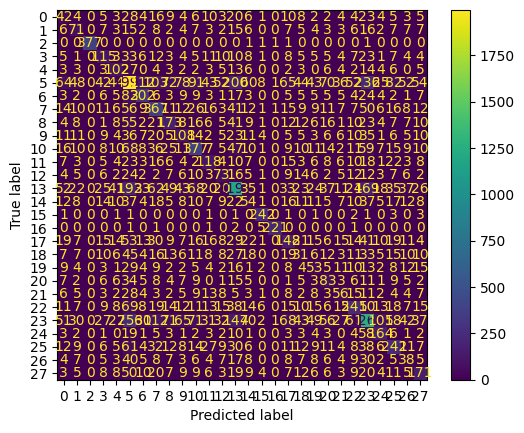

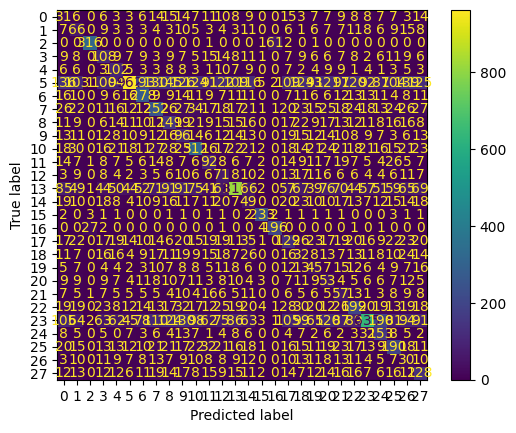

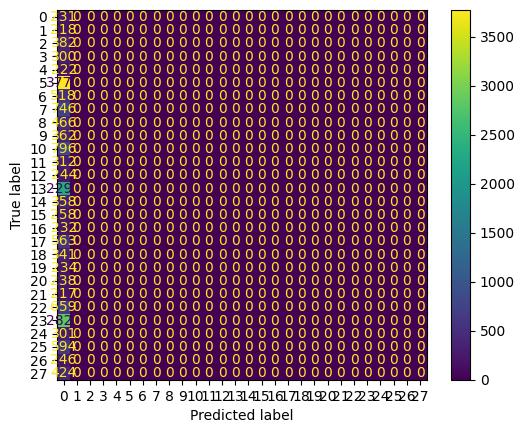

In [27]:
for x in models:
  n = model(x)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'max_depth': 10, 'n_estimators': 50}
Best Model Accuracy: 0.18390366172624237, Precision: 0.3318665047558034


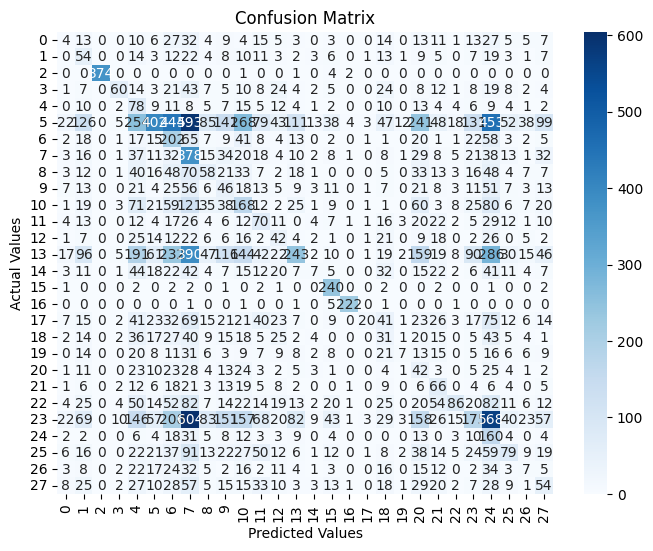

Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.02      0.02       231
           1       0.09      0.25      0.13       218
           2       1.00      0.98      0.99       382
           3       0.58      0.20      0.30       300
           4       0.06      0.35      0.11       222
           5       0.52      0.11      0.18      3770
           6       0.12      0.39      0.19       518
           7       0.13      0.51      0.20       746
           8       0.13      0.12      0.13       466
           9       0.06      0.13      0.08       362
          10       0.15      0.21      0.18       796
          11       0.13      0.22      0.17       312
          12       0.12      0.17      0.14       244
          13       0.41      0.11      0.17      2293
          14       0.11      0.02      0.03       358
          15       0.51      0.93      0.66       258
          16       0.95      0.96      0.95       232
    

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score

# Assuming X_train_smote, y_train_smote, X_test, y_test are already defined

# RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# Parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)
print("Best Parameters:", grid_search.best_params_)

# Best model from grid search
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Accuracy and Precision
best_accuracy = accuracy_score(y_test, y_pred_best)
best_precision = precision_score(y_test, y_pred_best, average='weighted')
print(f'Best Model Accuracy: {best_accuracy}, Precision: {best_precision}')

# Plotting Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_best))


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}


grid_search_lr = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid_lr, cv=3, n_jobs=-1, verbose=2)
grid_search_lr.fit(X_train_smote, y_train_smote)


print("Best Parameters for LR:", grid_search_lr.best_params_)

best_lr = grid_search_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test)
best_accuracy_lr = accuracy_score(y_test, y_pred_best_lr)
best_precision_lr = precision_score(y_test, y_pred_best_lr, average='weighted')

print(f'Best Model Accuracy for LR: {best_accuracy_lr}, Precision: {best_precision_lr}')


cm_lr = confusion_matrix(y_test, y_pred_best_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_best_lr))




Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters for LR: {'C': 0.1, 'solver': 'liblinear'}
Best Model Accuracy for LR: 0.08059067131647776, Precision: 0.1521713296139733


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
dtc = DecisionTreeClassifier(random_state=42)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)

print("Best Parameters:", grid_search.best_params_)

best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
best_precision = precision_score(y_test, y_pred_best, average='weighted')

print(f'Best Model Accuracy: {best_accuracy}, Precision: {best_precision}')


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Model Accuracy: 0.2963709677419355, Precision: 0.3814277598855319


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [5, 7, 9],
    'leaf_size': [20, 30, 40],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)

print("Best Parameters:", grid_search.best_params_)

best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
best_precision = precision_score(y_test, y_pred_best, average='weighted')

print(f'Best Model Accuracy: {best_accuracy}, Precision: {best_precision}')


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'leaf_size': 40, 'metric': 'manhattan', 'n_neighbors': 5}
Best Model Accuracy: 0.3051438535309503, Precision: 0.43861343653338697
